# Forecasting ARIMA - Air Passangers

### Librerías Python  

In [1]:
# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pylab
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
import itertools
warnings.filterwarnings("ignore")

## Data Wrangling<a name="datawrangling"></a>

Importamos y tratamos datos

### Gather data

In [3]:
# definición del dataframe
df = pd.read_csv('AirPassengers.csv')

### Propiedades Dataframe 

In [4]:
df.shape

(144, 2)

In [5]:
df.head()

,TravelDate,Passengers
0,1/1/1949,112
1,2/1/1949,118
2,3/1/1949,132
3,4/1/1949,129
4,5/1/1949,121


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
TravelDate    144 non-null object
Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [7]:
# Convertimos a fecha TravelDate
df['TravelDate'] = pd.to_datetime(df['TravelDate'])

In [8]:
# Asociamos la fecha al índice de la serie temporal ts
ts = df.set_index('TravelDate')

In [9]:
# Eliminamos NA
ts.dropna(inplace = True)

In [10]:
# Serie temporal tratada
ts.head()

,Passengers
TravelDate,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Serie temporal

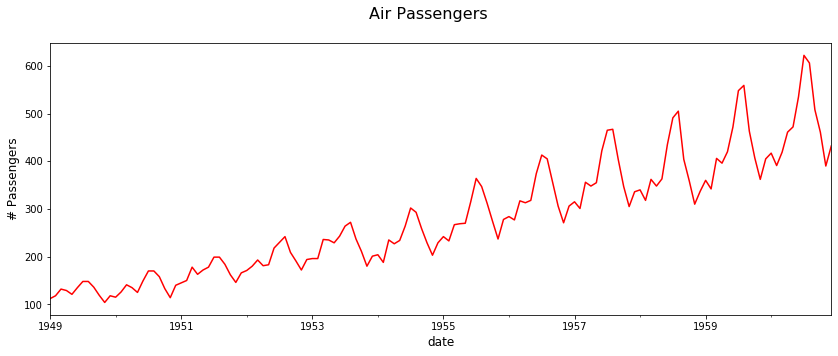

In [11]:

ts.plot(kind='line', legend = None, color='red', figsize = (14,5))
plt.suptitle('Air Passengers', size=16)
plt.ylabel('# Passengers', size=12)
plt.xlabel('date', size=12)
plt.show()

## Estacionariedad

Podemos observar que la serie poseee tendencia y una posible estacionalidad con frecuencias de 12 meses. Esto hace de nuestra serie una serie no estacionaria. A continuación vamos a visualizar cómo la medias móviles y la desviación típica móvil varían con la serie para confirmar que la serie no es estacionaria.

###  Media y desviación típica móvil

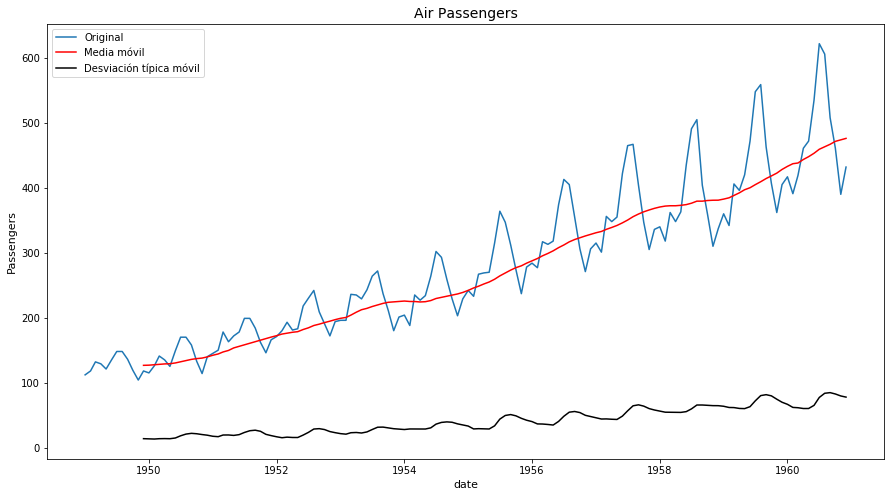

In [12]:
#Calculamos media móvil y desviación típica móvil con periodos de 12 meses (ciclo)

moving_avg = ts.rolling(12).mean()
moving_std = ts.rolling(12).std()

plt.figure(figsize=(15,8))

plt.plot(ts,label = 'Original')
plt.plot(moving_avg, color='red',label = 'Media móvil')
plt.plot(moving_std, color='black',label = 'Desviación típica móvil')

plt.yticks(fontsize = 10)
plt.xlabel('date', fontsize = 11)
plt.ylabel('Passengers', fontsize = 11)
plt.legend(loc = 'best')
plt.title('Air Passengers', fontsize = 14)
plt.show()

La media móvil **no se mantiene constante**, vemos con claridad en rojo una **tendencia** <br>
La desviación típica **tampoco se mantiene constante**.<br>
La serie **NO ES ESTACIONARIA**.

In [13]:
# cargamos statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [14]:
result = adfuller(ts['Passengers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.8153688792060543
p-value: 0.9918802434376411
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


### Diferenciación

Aplicamos logaritmos de cara a reducir las variaciones en la serie y favorecer el estacionamiento

In [15]:
#Aplicamos logaritmo
ts_log = np.log(ts)

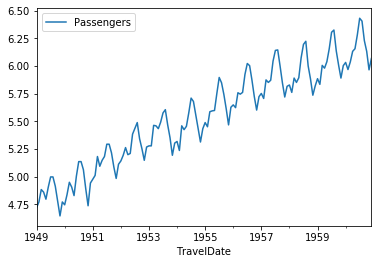

In [16]:
#Visualizamos
ts_log.plot()

Una manera de estacionalizar nuestra serie es diferenciando sobre los valores inmediatamente anteriores

In [17]:
ts_diff = ts_log - ts_log.shift(1) 
ts_diff.dropna(inplace = True)

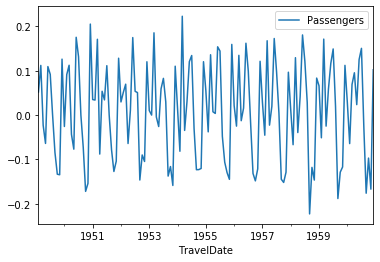

In [18]:
ts_diff.plot()

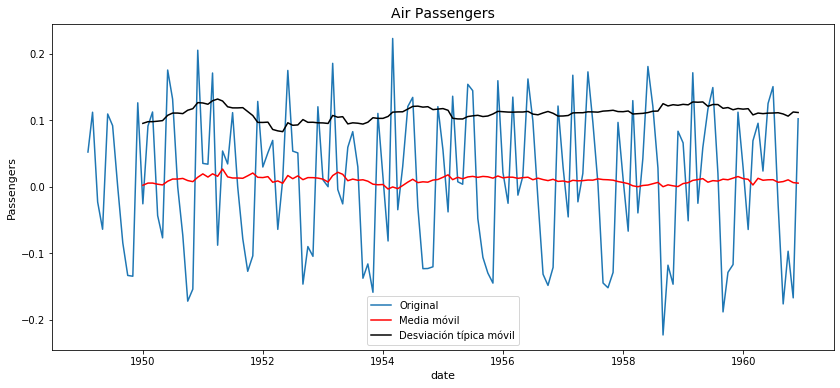

In [19]:
#Calculamos media móvil y desviación típica móvil (la estacionalidad es anual y por ello marcamos 12 meses)

moving_avg_diff = ts_diff.rolling(12).mean() #frecuencia de 12 meses
moving_std_diff = ts_diff.rolling(12).std() #frecuencia de 12 meses

plt.figure(figsize=(14,6))

plt.plot(ts_diff,label = 'Original')
plt.plot(moving_avg_diff, color='red',label = 'Media móvil')
plt.plot(moving_std_diff, color='black', label = 'Desviación típica móvil')

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('date', fontsize = 11)
plt.ylabel('Passengers', fontsize = 11)
plt.legend(loc = 'best')
plt.title('Air Passengers', fontsize = 14)
plt.show()

Una vez aplicada las medias y desviaciones típicas moviles móviles sobre el dataset diferenciado, observamos que la serie visualmente es estacionaria; el avg y std móvil son más o menos constantes.  

In [20]:
result = adfuller(ts_diff['Passengers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.7171305983881595
p-value: 0.07112054815085424
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


El p-value está por debajo de 0.05 y el índice ADF Statistic es cercano a los valores críticos, por lo que la esta **serie sería estacionaria.**

Otra manera de diferenciar sería diferenciando sobre la media móvil:

In [21]:
df_log_minus_avg = ts_diff - moving_avg_diff #Diferenciamos sobre la media móvil calculada previamente
df_log_minus_avg.dropna(inplace=True)
df_log_minus_avg.head()

,Passengers
TravelDate,
1950-01-01,-0.027955
1950-02-01,0.085883
1950-03-01,0.106981
1950-04-01,-0.047274
1950-05-01,-0.079671


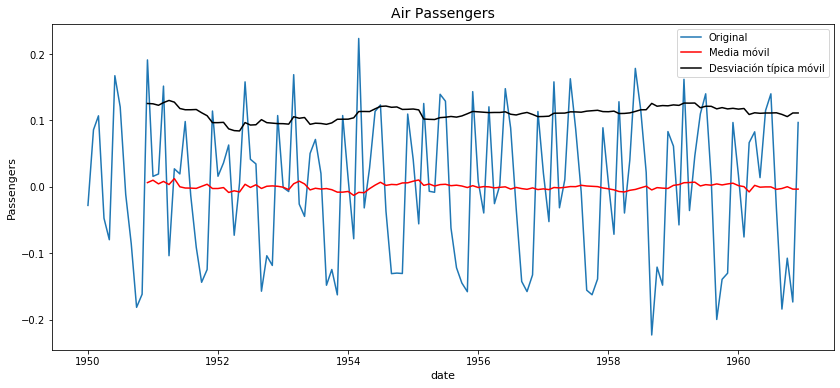

In [22]:
#Calculamos media móvil y desviación típica móvil (la estacionalidad es anual y por ello marcamos 12 meses)

moving_avg_diff2 = df_log_minus_avg.rolling(12).mean() #frecuencia de 12 meses
moving_std_diff2 = df_log_minus_avg.rolling(12).std() #frecuencia de 12 meses

plt.figure(figsize=(14,6))

plt.plot(df_log_minus_avg,label = 'Original')
plt.plot(moving_avg_diff2, color='red',label = 'Media móvil')
plt.plot(moving_std_diff2, color='black', label = 'Desviación típica móvil')

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('date', fontsize = 11)
plt.ylabel('Passengers', fontsize = 11)
plt.legend(loc = 'best')
plt.title('Air Passengers', fontsize = 14)
plt.show()

Vemos de nuevo que hemos estacionarizado de nuevo la serie; el avg y std móvil son más o menos constantes.  Veamos si en mayor grado que diferenciando sobre el registro anterior calculado previamente:

In [23]:
result = adfuller(df_log_minus_avg['Passengers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.9129812454195023
p-value: 0.0019413623769365547
Critical Values:
	1%: -3.4870216863700767
	5%: -2.8863625166643136
	10%: -2.580009026141913


El p-value ha mejorado (esta vez por debajo de 0.05) y ADF sigue cercano a los valores críticos

## Parámetros para el modelo ARIMA

Los forecast ARIMA para una serie temporal estacionaria es una ecuación lineal (como una regresión lineal), dependientes de los parámetros (p, d, q) del modelo ARIMA:

- **Número de términos AR (Auto-regresivos) (p)**: los términos AR los lags (retrasos) de la variable dependiente. Por ejemplo, si p es 5, los predictores para x (t) serán x (t-1) ... .x (t-5).
- **Número de términos MA (promedio móvil) (q)**: Es el número de órdenes de media móvil presentes en el modelo. Por ejemplo, los órdenes de media móvil de 1 y 2 especifican que las desviaciones del valor medio de la serie de cada uno de los dos últimos períodos de tiempo se tienen en cuenta al predecir los valores actuales de la serie. 
- **Número de diferencias (d)**: En un modelo ARIMA transformamos una serie temporal en una estacionaria (serie sin tendencia o estacionalidad) utilizando la diferenciación (Diferencia entre el tiempo actual y el anterior). D se refiere al número de transformaciones de diferenciación requeridas por las series de tiempo para volverse estacionarias (media y varianza constantes en el tiempo).

El problema suele residir en determinar el valor de "p" y "q". Utilizamos dos conceptos para determinar estos parámetros

- **Función de autocorrelación (ACF)**: es una medida de la correlación entre el TS con una versión retrasada de sí mismo. Por ejemplo, en el retraso 5, ACF compararía las series en el instante instantáneo "t1" ... "t2" con las series en el instante "t1-5" ... "t2-5" (t1-5 y t2 son los puntos finales).<br>
- **Función de autocorrelación parcial (PACF)**: mide la correlación entre el TS con una versión retrasada de sí mismo, pero después de eliminar las variaciones ya explicadas por las comparaciones intermedias. Por ejemplo, en el retraso 5, verificará la correlación pero eliminará los efectos ya explicados por los retrasos 1 a 4.

In [24]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

Distribución de ACF y PACF

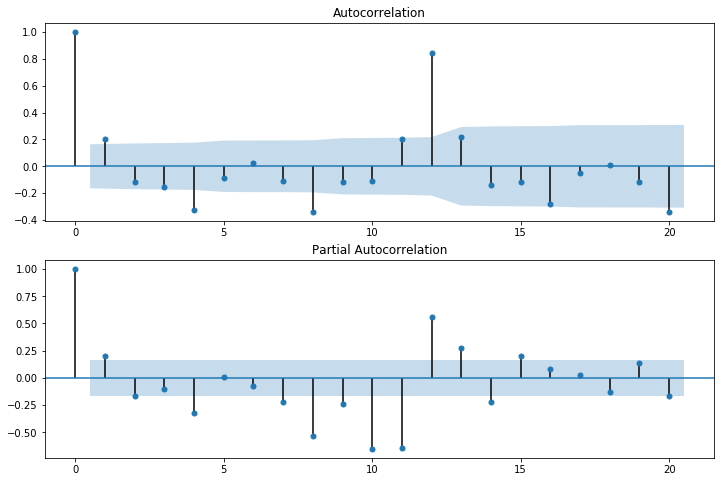

In [25]:
#ACF y PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff, lags=20, ax=ax2)

Distribución de ACF y PACF (2)

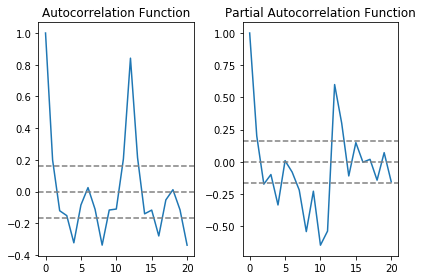

In [26]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Observamos que tanto para el ACF como el PACF las gráficas cortan el margen superior de confianza por primera vez en el lag = 2<br>

Esto implica: 

- **p=2** (PACF)
- **q=2** (ACF)

Hemos realizado una diferenciación por lo que **d=1**

## Entrenamiento

Entrenamos nuestro modelo ARIMA(2,1,2)

C:\Users\marco\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\marco\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


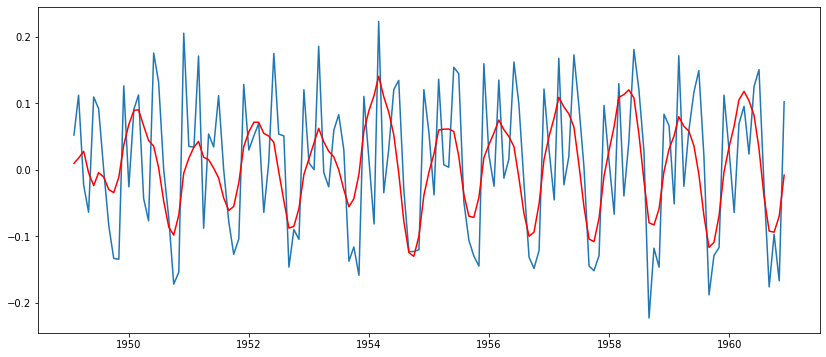

In [27]:
decomposition = seasonal_decompose(ts_log) 
model = ARIMA(ts_log, order=(2,1,2))
results = model.fit(disp=-1)

plt.figure(figsize=(14,6))

plt.plot(ts_diff)
plt.plot(results.fittedvalues, color='red')


LLevamos el modelo a nuestra serie original

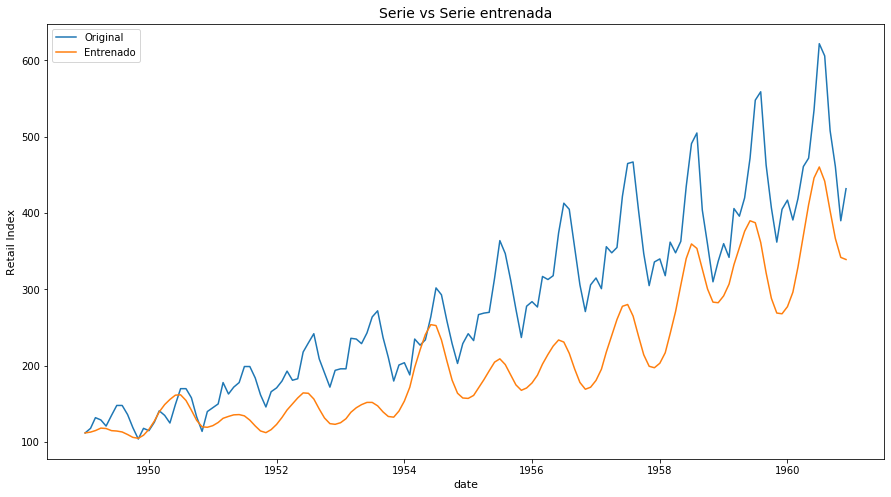

In [28]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log['Passengers'].iloc[0], index = ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)



plt.figure(figsize=(15,8))

plt.plot(ts, label = 'Original')
plt.plot(predictions_ARIMA, label ='Entrenado')


plt.yticks(fontsize = 10)
plt.xlabel('date', fontsize = 11)
plt.ylabel('Retail Index', fontsize = 11)
plt.legend(loc = 'best')
plt.title('Serie vs Serie entrenada', fontsize = 14)
plt.show()

## Forecast

Para predecir los datos de los próximos 10 años y dado que tenemos los datos de 12 años, (12x12) + 12x10 = 264

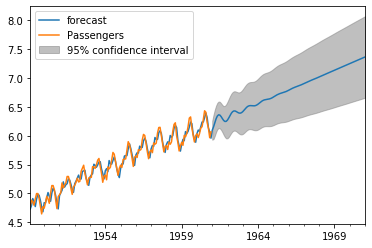

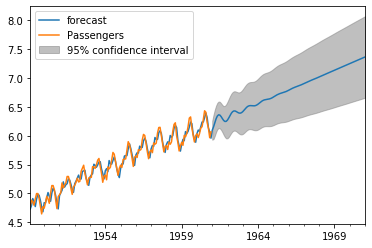

In [29]:
results.plot_predict(1,264)